# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [22]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

import nltk

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

%matplotlib inline

import load_lee_background_corpus as load_texts

Analysing our corpus.
    - The first document talks about a bushfire that had occured in New South Wales.
    - The second talks about conflict between India and Pakistan in Kashmir.
    - The third talks about road accidents in the New South Wales area.
    - The fourth one talks about Argentina's economic and political crisis during that time.
    - The last one talks about the use of drugs by midwives in a Sydney hospital.
Our final topic model should be giving us keywords which we can easily interpret and make a small summary out of. Without this the topic model cannot be of much practical use.

In [2]:
lee_train_file = load_texts.get_lee_train_file()
with open(lee_train_file) as f:
    for n, l in enumerate(f):
        if n < 6:
            print([l])

/home/pedro.castro/anaconda3/lib/python3.6/site-packages/gensim/test/test_data
['Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called 

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [3]:
texts = load_texts.get_raw_texts()
print(texts[5])

/home/pedro.castro/anaconda3/lib/python3.6/site-packages/gensim/test/test_data
The Federal Government says it should be safe for Afghani asylum seekers in Australia to return home when the environment becomes secure. The Government has suspended their applications while the interim government is established in Kabul. The Foreign Affairs Minister Alexander Downer has refused to say for how long the claims process has been put on hold. But he says the major threat to most people seeking asylum is no longer there. "Many Afghans who have tried to get into Australia or for that matter into Britain and other countries in north-west Europe have claimed that they are fleeing the Taliban," he said. "Well, the Taliban is no longer in power in Afghanistan, the Taliban is finished." Meanwhile, there has been a mass airlift of detainees from Christmas Island to the Pacific Island of Nauru. In total, more than 300 people have been flown from the island in two operations using chartered aircraft. The

In [4]:
texts = load_texts.process_file(lee_train_file, keep_all=True)
print(texts[5])

['federal_government', 'says', 'safe', 'afghani', 'asylum_seekers', 'australia', 'return', 'home', 'environment', 'becomes', 'secure', 'government', 'suspended', 'applications', 'interim_government', 'established', 'kabul', 'foreign_affairs', 'minister_alexander', 'downer', 'refused', 'say', 'long', 'claims', 'process', 'has_been', 'put', 'hold', 'says', 'major', 'threat', 'people', 'seeking', 'asylum', 'longer', 'many', 'afghans', 'tried', 'get', 'australia', 'matter', 'britain', 'countries', 'north', 'west', 'europe', 'claimed', 'they_are', 'fleeing', 'taliban', 'said', 'well', 'taliban', 'longer', 'power', 'afghanistan', 'taliban', 'finished', 'meanwhile', 'has_been', 'mass', 'airlift', 'detainees', 'christmas', 'island', 'pacific', 'island', 'nauru', 'total', 'more_than', 'people', 'have_been', 'flown', 'island', 'two', 'operations', 'using', 'chartered', 'aircraft', 'second', 'airlift', 'today', 'delivered', 'asylum_seekers', 'nauru', 'await', 'processing', 'claims', 'temporary', 

In [4]:
train_texts = load_texts.process_file(lee_train_file, keep_all=False)
print(train_texts[5])

['federal_government', 'afghani', 'asylum_seekers', 'australia', 'home', 'environment', 'secure', 'government', 'applications', 'government', 'kabul', 'foreign_affairs', 'minister_alexander', 'downer', 'claims', 'process', 'hold', 'threat', 'people', 'asylum', 'afghans', 'australia', 'matter', 'britain', 'countries', 'europe', 'taliban', 'taliban', 'power', 'afghanistan', 'taliban', 'mass', 'airlift', 'detainees', 'christmas', 'island', 'pacific', 'island', 'nauru', 'people', 'island', 'operations', 'aircraft', 'airlift', 'today', 'asylum_seekers', 'nauru', 'processing', 'claims', 'visas', 'department', 'immigration', 'detainees', 'christmas', 'island', 'spokesman', 'decision', 'future']


Finalising our dictionary and corpus

In [5]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [6]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [7]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.338*"arafat" + 0.234*"government" + 0.201*"people" + 0.194*"afghanistan" + 0.193*"security" + 0.172*"australia" + 0.161*"israeli" + 0.143*"forces" + 0.138*"israel" + 0.132*"police"'),
 (1,
  '-0.447*"arafat" + 0.265*"afghanistan" + 0.234*"australia" + -0.208*"israeli" + -0.179*"sharon" + -0.178*"israel" + -0.149*"west_bank" + -0.130*"hamas" + 0.120*"afghan" + 0.117*"taliban"'),
 (2,
  '0.328*"afghanistan" + -0.251*"australia" + -0.193*"test" + -0.177*"sydney" + 0.172*"afghan" + 0.163*"forces" + 0.161*"laden" + -0.160*"fire" + 0.157*"taliban" + 0.132*"tora_bora"'),
 (3,
  '-0.346*"australia" + 0.325*"fire" + 0.242*"sydney" + -0.223*"test" + 0.198*"firefighters" + 0.163*"fires" + 0.152*"new_south" + 0.152*"wales" + -0.151*"match" + 0.149*"areas"'),
 (4,
  '-0.310*"company" + 0.284*"test" + -0.261*"qantas" + -0.183*"workers" + -0.174*"commission" + -0.162*"unions" + 0.146*"south_africa" + -0.139*"government" + 0.135*"match" + -0.126*"action"')]

In [8]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [9]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [10]:
hdpmodel.show_topics()

[(0,
  '0.005*company + 0.003*australia + 0.003*staff + 0.002*disagreements + 0.002*entitlements + 0.002*austar + 0.002*thatcher + 0.002*television + 0.002*administrators + 0.002*traveland + 0.002*lion + 0.001*debris + 0.001*cataract + 0.001*lording + 0.001*paris + 0.001*swimmer + 0.001*blaze + 0.001*baton + 0.001*air_strikes + 0.001*bankruptcy'),
 (1,
  '0.004*israeli + 0.004*arafat + 0.003*sharon + 0.002*authority + 0.002*west_bank + 0.002*official + 0.001*murder + 0.001*militants + 0.001*protectors + 0.001*timothy + 0.001*hawkesbury + 0.001*incomes + 0.001*israelis + 0.001*air_strikes + 0.001*composition + 0.001*northern_territory + 0.001*breakdown + 0.001*offices + 0.001*afternoon + 0.001*gang'),
 (2,
  '0.003*krishna + 0.003*benares + 0.003*hare + 0.003*ashes + 0.002*harrison + 0.002*genius + 0.002*ganges + 0.002*everything + 0.002*wider + 0.002*river + 0.002*devotees + 0.002*ceremony + 0.002*hundreds + 0.001*positions + 0.001*refugee + 0.001*fans + 0.001*hindus + 0.001*shop + 0.0

In [11]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [12]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [13]:
import pyLDAvis.gensim

In [14]:
pyLDAvis.enable_notebook()

In [15]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/home/pedro.castro/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      19.211811        1       1 -0.064780  0.021139
5      12.772690        1       2 -0.045137 -0.090052
3      11.118162        1       3 -0.049040  0.057347
6      11.058075        1       4  0.098003  0.002478
2      10.231109        1       5  0.062682  0.048642
7       9.707473        1       6  0.026834  0.022616
4       9.200910        1       7 -0.022916  0.027925
1       8.449295        1       8 -0.046361  0.014278
8       4.246826        1       9  0.042438 -0.060229
9       4.003649        1      10 -0.001725 -0.044144, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
35    Default   49.000000         fire   49.000000  30.0000  30.0000
596   Default   41.000000         test   41.000000  29.0000  29.0000
845   Default   73.000000       arafat   73.000000  28.0000  28.0000
220   Default   78.000000  afghanistan   78.000000  27.0000  27.0000
131   Default  134.000000    australia  134.000000  26.0000  26.0000
511   Default   36.000000       afghan   36.000000  25.0000  25.0000
223   Default   16.000000    detainees   16.000000  24.0000  24.0000
75    Default   66.000000     security   66.000000  23.0000  23.0000
90    Default   68.000000       police   68.000000  22.0000  22.0000
912   Default   28.000000       metres   28.000000  21.0000  21.0000
165   Default  114.000000   government  114.000000  20.0000  20.0000
1562  Default   27.000000        hamas   27.000000  19.0000  19.0000
1382  Default   14.000000      airport   14.000000  18.0000  18.0000
2584  Default   13.000000        space   13.000000  17.0000  17.0000
466   Default   29.000000        group   29.000000  16.0000  16.0000
1516  Default   26.000000    tora_bora   26.000000  15.0000  15.0000
394   Default   40.000000        force   40.000000  14.0000  14.0000
95    Default   29.000000        india   29.000000  13.0000  13.0000
724   Default   12.000000       flight   12.000000  12.0000  12.0000
1687  Default   27.000000       qantas   27.000000  11.0000  11.0000
42    Default   63.000000         year   63.000000  10.0000  10.0000
537   Default   43.000000      israeli   43.000000   9.0000   9.0000
808   Default    6.000000         reid    6.000000   8.0000   8.0000
1     Default  113.000000       people  113.000000   7.0000   7.0000
1150  Default   20.000000        radio   20.000000   6.0000   6.0000
865   Default   31.000000       centre   31.000000   5.0000   5.0000
310   Default   19.000000        river   19.000000   4.0000   4.0000
1449  Default   23.000000        child   23.000000   3.0000   3.0000
1369  Default   16.000000     kandahar   16.000000   2.0000   2.0000
4029  Default    6.000000        virus    6.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
1150  Topic10    2.987388        radio   20.497116   1.2921  -5.5325
263   Topic10    0.969634      minutes    3.461669   1.9454  -6.6577
1876  Topic10    2.911672     children   24.179185   1.1012  -5.5582
1854  Topic10    1.243053         data    5.690172   1.6968  -6.4093
432   Topic10    1.834153    buildings   11.894107   1.3485  -6.0203
42    Topic10    4.314232         year   63.187362   0.5338  -5.1650
75    Topic10    4.375606     security   66.368200   0.4988  -5.1508
865   Topic10    2.811515       centre   31.029306   0.8168  -5.5932
196   Topic10    3.063153       action   38.459107   0.6878  -5.5074
1429  Topic10    1.004748      project    4.381407   1.7453  -6.6222
1889  Topic10    0.893862    ambulance    3.495422   1.8543  -6.7391
1562  Topic10    2.377645        hamas   27.342069   0.7756  -5.7608
681   Topic10    1.541279          boy   11.133069   1.2407  -6.1943
152   Topic10    2.739240        years   39.297377   0.5545  -5.6192
845   Topic10    3.567635       arafat   73.265257   0.1958  -5.35

In [16]:
ldatopics = ldamodel.show_topics(formatted=False)

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [17]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

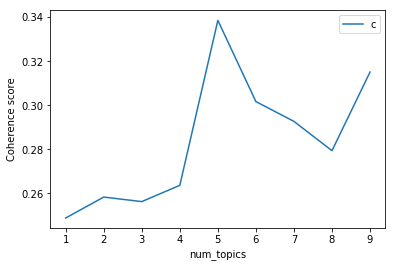

CPU times: user 18.9 s, sys: 204 ms, total: 19.1 s
Wall time: 19.9 s


In [18]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)

In [19]:
pyLDAvis.gensim.prepare(lmlist[4], corpus, dictionary)

/home/pedro.castro/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      26.261758        1       1  0.006513  0.059807
2      22.837452        1       2 -0.023168  0.011005
4      20.740263        1       3 -0.048551 -0.023553
1      15.543030        1       4  0.063257 -0.019345
0      14.617497        1       5  0.001949 -0.027913, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
131   Default  122.000000       australia  122.000000  30.0000  30.0000
912   Default   28.000000          metres   28.000000  29.0000  29.0000
394   Default   38.000000           force   38.000000  28.0000  28.0000
596   Default   40.000000            test   40.000000  27.0000  27.0000
845   Default   73.000000          arafat   73.000000  26.0000  26.0000
223   Default   18.000000       detainees   18.000000  25.0000  25.0000
199   Default   14.000000  asylum_seekers   14.000000  24.0000  24.0000
511   Default   36.000000          afghan   36.000000  23.0000  23.0000
310   Default   19.000000           river   19.000000  22.0000  22.0000
1234  Default   39.000000          israel   39.000000  21.0000  21.0000
247   Default   26.000000           match   26.000000  20.0000  20.0000
128   Default   18.000000      queensland   18.000000  19.0000  19.0000
724   Default   12.000000          flight   12.000000  18.0000  18.0000
591   Default   23.000000    south_africa   23.000000  17.0000  17.0000
220   Default   74.000000     afghanistan   74.000000  16.0000  16.0000
1641  Default   13.000000    hollingworth   13.000000  15.0000  15.0000
3465  Default    5.000000  world_heritage    5.000000  14.0000  14.0000
3753  Default    5.000000        products    5.000000  13.0000  13.0000
537   Default   43.000000         israeli   43.000000  12.0000  12.0000
1150  Default   21.000000           radio   21.000000  11.0000  11.0000
42    Default   63.000000            year   63.000000  10.0000  10.0000
204   Default   14.000000           kabul   14.000000   9.0000   9.0000
219   Default   27.000000           power   27.000000   8.0000   8.0000
572   Default   15.000000            boat   15.000000   7.0000   7.0000
1091  Default   10.000000           waugh   10.000000   6.0000   6.0000
679   Default   50.000000             man   50.000000   5.0000   5.0000
1368  Default   14.000000         weapons   14.000000   4.0000   4.0000
226   Default    7.000000         pacific    7.000000   3.0000   3.0000
1687  Default   28.000000          qantas   28.000000   2.0000   2.0000
3190  Default    6.000000         friedli    6.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1638   Topic5    2.841820        anglican    6.923281   1.0325  -6.8775
843    Topic5    6.766160       statement   21.765192   0.7546  -6.0100
718    Topic5    4.813810           plane   13.939812   0.8597  -6.3504
131    Topic5   21.733476       australia  122.842737   0.1909  -4.8430
472    Topic5    6.560504           talks   22.895966   0.6731  -6.0408
125    Topic5   11.871312            time   54.025809   0.4076  -5.4478
591    Topic5    6.504580    south_africa   23.059689   0.6574  -6.0494
75     Topic5   13.185025        security   65.250714   0.3238  -5.3428
693    Topic5    5.975927         federal   20.892428   0.6713  -6.1342
1293   Topic5    4.947626         cricket   15.927040   0.7538  -6.3230
513    Topic5    5.755918       agreement   20.321878   0.6615  -6.1717
138    Topic5    8.629418       president   39.226072   0.4088  -5.7667
511    Topic5    8.169297          afghan   36.069207   0.4379  -5.8215
1      Topic5   16.153200          people  112.740028  -0.0200  -5.1398
236    Topic5   10.520138   united_states   58.816684   0.2018  -5.5686
8      Topic5   10.247353           today   62.400549   0.1164  -5.5949
473    Topic5    6.252416  prime_minister   25.2739

In [20]:
lmtopics = lmlist[4].show_topics(formatted=False)

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [27]:
def get_best_model_by_topics(dictionary, corpus, texts, starting=10, limit=101, step=10, chunksize=300, passes=5, iterations=200):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in np.arange(starting, limit, step):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [26]:
%%time
best_model_full, lm_full, c_v_full = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts)
print(best_model_full.show_topics(formatted=True))

2017-11-20 11:40:15,002 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-11-20 11:40:15,004 : INFO : using serial LDA version on this node
2017-11-20 11:40:15,481 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 11:40:15,481 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 11:40:16,111 : DEBUG : bound: at document #0
2017-11-20 11:40:17,619 : INFO : -11.613 per-word bound, 3133.1 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 1

2017-11-20 11:40:22,567 : INFO : topic #9 (0.063): 0.017*"arafat" + 0.008*"security" + 0.008*"israeli" + 0.006*"government" + 0.006*"pakistan" + 0.006*"israel" + 0.006*"union" + 0.006*"attacks" + 0.005*"west_bank" + 0.005*"sharon"
2017-11-20 11:40:22,568 : INFO : topic diff=0.231241, rho=0.447214
2017-11-20 11:40:22,742 : DEBUG : bound: at document #0
2017-11-20 11:40:23,350 : INFO : -7.758 per-word bound, 216.5 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:40:23,351 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 11:40:23,351 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:40:23,522 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 11:40:23,526 : INFO : optimized alpha [0.036456748405669911, 0.037651093688834632, 0.043652981067461336, 0.044031735384626597, 0.036810110800781233, 0.044388986783863563, 0.047870970499097179, 0.046232610803120577, 0.055482676591535482, 0.05974074496798

2017-11-20 11:40:32,182 : INFO : topic #5 (0.035): 0.007*"information" + 0.007*"data" + 0.007*"chechen" + 0.006*"troops" + 0.006*"party" + 0.006*"people" + 0.006*"city" + 0.006*"river" + 0.006*"laws" + 0.006*"hollingworth"
2017-11-20 11:40:32,183 : INFO : topic #7 (0.035): 0.011*"year" + 0.010*"report" + 0.007*"sultan" + 0.007*"whiting" + 0.007*"people" + 0.007*"safety" + 0.006*"attacks" + 0.006*"authority" + 0.005*"court" + 0.005*"violence"
2017-11-20 11:40:32,185 : INFO : topic #17 (0.040): 0.026*"arafat" + 0.014*"israeli" + 0.013*"sharon" + 0.011*"west_bank" + 0.011*"australia" + 0.007*"islamic" + 0.007*"leader" + 0.006*"government" + 0.006*"security" + 0.006*"people"
2017-11-20 11:40:32,187 : INFO : topic #16 (0.041): 0.012*"afghanistan" + 0.010*"people" + 0.010*"government" + 0.009*"qantas" + 0.006*"taliban" + 0.006*"force" + 0.006*"action" + 0.006*"time" + 0.006*"forces" + 0.006*"united_states"
2017-11-20 11:40:32,188 : INFO : topic #14 (0.041): 0.010*"australia" + 0.010*"man" + 

2017-11-20 11:40:36,836 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-20 11:40:36,859 : DEBUG : observed sentinel value; terminating
2017-11-20 11:40:36,887 : DEBUG : finished all batches; 64 documents processed (305 virtual)
2017-11-20 11:40:36,895 : DEBUG : completed batch 1; 128 documents processed (332 virtual)
2017-11-20 11:40:36,898 : INFO : serializing accumulator to return to master...
2017-11-20 11:40:36,897 : DEBUG : observed sentinel value; terminating
2017-11-20 11:40:36,898 : DEBUG : completed batch 1; 108 documents processed (485 virtual)
2017-11-20 11:40:36,902 : INFO : accumulator serialized
2017-11-20 11:40:36,903 : DEBUG : observed sentinel value; terminating
2017-11-20 11:40:36,907 : DEBUG : finished all batches; 108 documents processed (485 virtual)
2017-11-20 11:40:36,906 : DEBUG : finished all batches; 128 documents processed (332 virtual)
2017-11-20 11:40:36,914 : INFO : serializing accumulator to return to master...
2017-11-20 11:40:3

2017-11-20 11:40:47,784 : DEBUG : updating topics
2017-11-20 11:40:48,063 : INFO : topic #26 (0.025): 0.020*"hollingworth" + 0.016*"governor_general" + 0.016*"child" + 0.015*"vaughan" + 0.015*"ice" + 0.015*"abuse" + 0.013*"brisbane" + 0.012*"sea" + 0.012*"antarctic" + 0.011*"school"
2017-11-20 11:40:48,063 : INFO : topic #18 (0.025): 0.020*"company" + 0.015*"party" + 0.011*"groups" + 0.009*"attack" + 0.009*"staff" + 0.009*"labor" + 0.009*"entitlements" + 0.009*"review" + 0.009*"austar" + 0.009*"rule"
2017-11-20 11:40:48,065 : INFO : topic #17 (0.028): 0.011*"government" + 0.011*"afghan" + 0.010*"work" + 0.009*"people" + 0.008*"talks" + 0.008*"afghanistan" + 0.008*"president" + 0.007*"australia" + 0.006*"drug" + 0.006*"year"
2017-11-20 11:40:48,068 : INFO : topic #0 (0.028): 0.017*"afghanistan" + 0.011*"people" + 0.011*"united_states" + 0.010*"taliban" + 0.009*"police" + 0.009*"australian" + 0.008*"federal" + 0.007*"government" + 0.007*"forces" + 0.007*"officials"
2017-11-20 11:40:48,07

2017-11-20 11:40:52,927 : INFO : using serial LDA version on this node
2017-11-20 11:40:54,868 : INFO : running online (multi-pass) LDA training, 40 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 11:40:54,869 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 11:40:57,010 : DEBUG : bound: at document #0
2017-11-20 11:40:59,237 : INFO : -30.116 per-word bound, 1163942693.6 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:40:59,238 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 11:40:59,239 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:41:00,977 : DEBUG : 245/300 documents converged within 200 iterations
2017-11-20 11:41:00,981 : INFO : optimized alpha

2017-11-20 11:41:04,585 : INFO : topic #19 (0.022): 0.022*"security" + 0.021*"arafat" + 0.017*"israeli" + 0.014*"government" + 0.013*"israel" + 0.013*"hamas" + 0.010*"official" + 0.009*"west_bank" + 0.009*"forces" + 0.008*"president"
2017-11-20 11:41:04,587 : INFO : topic diff=0.820099, rho=0.500000
2017-11-20 11:41:04,887 : DEBUG : bound: at document #0
2017-11-20 11:41:05,645 : INFO : -8.061 per-word bound, 267.1 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:41:05,647 : INFO : PROGRESS: pass 3, at document #300/300
2017-11-20 11:41:05,648 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:41:05,947 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 11:41:05,953 : INFO : optimized alpha [0.02001540149571604, 0.02018649438331355, 0.020086515952415163, 0.021074061311415527, 0.019730125143195859, 0.018792906140500418, 0.020846429963964332, 0.020900266174248155, 0.020148946675490231, 0.0205202994896

2017-11-20 11:41:15,593 : DEBUG : bound: at document #0
2017-11-20 11:41:18,016 : INFO : -37.751 per-word bound, 231283583736.2 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:41:18,017 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 11:41:18,018 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:41:19,942 : DEBUG : 250/300 documents converged within 200 iterations
2017-11-20 11:41:19,947 : INFO : optimized alpha [0.018830577824870173, 0.019053783515962847, 0.01882760482086111, 0.018613348822998421, 0.018470988016492221, 0.018255261948795291, 0.018546311854067597, 0.018761212856415074, 0.01824881893965757, 0.018759556830729714, 0.019053387126056965, 0.018544964066398269, 0.018182795351683444, 0.01861681182618867, 0.018686687360534818, 0.018254719647404043, 0.018761083829208922, 0.018984499491508461, 0.018832050648414849, 0.019054240006437122, 0.019050664209102761, 0.018471964945656429, 0.018837785559871385,

2017-11-20 11:41:23,946 : INFO : topic #31 (0.018): 0.029*"afghanistan" + 0.019*"force" + 0.015*"laden" + 0.012*"qaeda" + 0.011*"government" + 0.011*"afghan" + 0.011*"forces" + 0.011*"australia" + 0.010*"tora_bora" + 0.010*"kabul"
2017-11-20 11:41:23,949 : INFO : topic diff=0.918413, rho=0.500000
2017-11-20 11:41:24,270 : DEBUG : bound: at document #0
2017-11-20 11:41:25,111 : INFO : -8.100 per-word bound, 274.3 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:41:25,112 : INFO : PROGRESS: pass 3, at document #300/300
2017-11-20 11:41:25,112 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:41:25,458 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 11:41:25,463 : INFO : optimized alpha [0.017355004116172943, 0.017703275558878941, 0.017288230398214862, 0.016791064477605505, 0.016586858893589226, 0.016153476467411759, 0.016861119569481119, 0.017182063555161848, 0.015972876672010288, 0.01717761861168

2017-11-20 11:41:30,879 : INFO : using serial LDA version on this node
2017-11-20 11:41:33,835 : INFO : running online (multi-pass) LDA training, 60 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 11:41:33,835 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 11:41:36,980 : DEBUG : bound: at document #0
2017-11-20 11:41:39,437 : INFO : -45.839 per-word bound, 62945271403382.0 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:41:39,438 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 11:41:39,438 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:41:41,646 : DEBUG : 245/300 documents converged within 200 iterations
2017-11-20 11:41:41,652 : INFO : optimized a

2017-11-20 11:41:45,439 : DEBUG : updating topics
2017-11-20 11:41:45,782 : INFO : topic #3 (0.014): 0.052*"fire" + 0.019*"flames" + 0.019*"smoke" + 0.013*"building" + 0.013*"new_york" + 0.013*"damage" + 0.013*"firefighters" + 0.013*"blaze" + 0.013*"church" + 0.013*"shop"
2017-11-20 11:41:45,783 : INFO : topic #22 (0.014): 0.022*"francs" + 0.019*"month" + 0.019*"rate" + 0.018*"months" + 0.014*"work" + 0.014*"jobs" + 0.014*"figures" + 0.014*"unemployment" + 0.014*"action" + 0.014*"verdict"
2017-11-20 11:41:45,784 : INFO : topic #59 (0.016): 0.027*"metres" + 0.015*"government" + 0.014*"australia" + 0.012*"night" + 0.011*"event" + 0.010*"india" + 0.010*"detainees" + 0.009*"race" + 0.008*"water" + 0.007*"world"
2017-11-20 11:41:45,786 : INFO : topic #12 (0.016): 0.017*"afghanistan" + 0.016*"people" + 0.016*"united_states" + 0.012*"police" + 0.011*"reports" + 0.011*"hewitt" + 0.011*"australian" + 0.010*"world" + 0.009*"hicks" + 0.008*"australia"
2017-11-20 11:41:45,787 : INFO : topic #29 (0

2017-11-20 11:41:50,647 : INFO : serializing accumulator to return to master...
2017-11-20 11:41:50,648 : DEBUG : finished all batches; 128 documents processed (332 virtual)
2017-11-20 11:41:50,651 : INFO : accumulator serialized
2017-11-20 11:41:50,661 : INFO : serializing accumulator to return to master...
2017-11-20 11:41:50,686 : INFO : accumulator serialized
2017-11-20 11:41:50,748 : DEBUG : completed batch 1; 108 documents processed (485 virtual)
2017-11-20 11:41:50,752 : DEBUG : observed sentinel value; terminating
2017-11-20 11:41:50,753 : DEBUG : finished all batches; 108 documents processed (485 virtual)
2017-11-20 11:41:50,765 : INFO : serializing accumulator to return to master...
2017-11-20 11:41:50,771 : INFO : accumulator serialized
2017-11-20 11:41:50,840 : INFO : 3 accumulators retrieved from output queue
2017-11-20 11:41:50,911 : INFO : accumulated word occurrence stats for 1122 virtual documents
2017-11-20 11:41:53,644 : INFO : using autotuned alpha, starting with [0

2017-11-20 11:42:11,978 : DEBUG : updating topics
2017-11-20 11:42:12,403 : INFO : topic #38 (0.013): 0.000*"people" + 0.000*"australia" + 0.000*"day" + 0.000*"government" + 0.000*"today" + 0.000*"united_states" + 0.000*"days" + 0.000*"time" + 0.000*"year" + 0.000*"yesterday"
2017-11-20 11:42:12,407 : INFO : topic #35 (0.013): 0.000*"people" + 0.000*"australia" + 0.000*"day" + 0.000*"government" + 0.000*"today" + 0.000*"united_states" + 0.000*"days" + 0.000*"time" + 0.000*"year" + 0.000*"yesterday"
2017-11-20 11:42:12,414 : INFO : topic #42 (0.014): 0.013*"australia" + 0.011*"afghanistan" + 0.011*"government" + 0.011*"race" + 0.010*"union" + 0.010*"people" + 0.008*"year" + 0.008*"pay" + 0.008*"today" + 0.008*"pakistan"
2017-11-20 11:42:12,415 : INFO : topic #12 (0.014): 0.017*"government" + 0.013*"labor" + 0.012*"radio" + 0.010*"world" + 0.010*"year" + 0.009*"time" + 0.009*"australia" + 0.008*"firefighters" + 0.007*"economy" + 0.007*"boat"
2017-11-20 11:42:12,416 : INFO : topic #6 (0.0

2017-11-20 11:42:20,072 : INFO : optimized alpha [0.011929532484229032, 0.01196915737580824, 0.012050641483990055, 0.012682002674389429, 0.012090998848417647, 0.012291820711091424, 0.013853959501511815, 0.012330673493130077, 0.012706125759296175, 0.012745467924464097, 0.012416966056045338, 0.01229555281832965, 0.013323323961811942, 0.012584192207028071, 0.012600134272211709, 0.01237586646810695, 0.012052668961865076, 0.012861463073015491, 0.012517377595210042, 0.012332179590890304, 0.012008538355272056, 0.012173365698431455, 0.012396388311251918, 0.012292430822495353, 0.012334465224828254, 0.01217139626103083, 0.011930013129794767, 0.012505035859478195, 0.01241745626587488, 0.012112951428069103, 0.012293364175075764, 0.012170989947141468, 0.011930879148632804, 0.012469875222507226, 0.01270078476983794, 0.011810726724222282, 0.012460937828553056, 0.012417466225865164, 0.011810726724222282, 0.012170176774618586, 0.012090008853741945, 0.01229552206492065, 0.013113280491605595, 0.012540951

2017-11-20 11:42:41,020 : DEBUG : updating topics
2017-11-20 11:42:41,391 : INFO : topic #54 (0.012): 0.000*"collins" + 0.000*"mounted" + 0.000*"kingham" + 0.000*"martin" + 0.000*"victorian" + 0.000*"slogans" + 0.000*"intersection" + 0.000*"hawke" + 0.000*"square" + 0.000*"cfmeu"
2017-11-20 11:42:41,392 : INFO : topic #33 (0.012): 0.046*"hamas" + 0.032*"official" + 0.025*"israeli" + 0.021*"israel" + 0.021*"arafat" + 0.016*"operations" + 0.013*"defence" + 0.011*"movement" + 0.011*"fatah" + 0.011*"focus"
2017-11-20 11:42:41,394 : INFO : topic #41 (0.012): 0.017*"government" + 0.011*"australia" + 0.011*"security" + 0.009*"arafat" + 0.008*"september" + 0.008*"world" + 0.007*"attacks" + 0.007*"forces" + 0.007*"people" + 0.007*"way"
2017-11-20 11:42:41,396 : INFO : topic #35 (0.012): 0.014*"pakistan" + 0.011*"people" + 0.009*"drug" + 0.009*"measures" + 0.009*"area" + 0.008*"australia" + 0.008*"forces" + 0.008*"members" + 0.007*"tora_bora" + 0.007*"police"
2017-11-20 11:42:41,398 : INFO : top

2017-11-20 11:42:47,468 : INFO : topic diff=1.123924, rho=0.500000
2017-11-20 11:42:47,805 : DEBUG : bound: at document #0
2017-11-20 11:42:49,765 : INFO : -8.300 per-word bound, 315.1 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:42:49,767 : INFO : PROGRESS: pass 3, at document #300/300
2017-11-20 11:42:49,768 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:42:50,537 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 11:42:50,546 : INFO : optimized alpha [0.011233303653230152, 0.011135842543051768, 0.011099507526409506, 0.0110988758787913, 0.011002169059490106, 0.011603775428331783, 0.01124553686754653, 0.011002727318884869, 0.011511086704534365, 0.011504843547371682, 0.011003217539639469, 0.010906729020322187, 0.011096292442581429, 0.011428067941056769, 0.011489005505092301, 0.011390964228314935, 0.011234222560675779, 0.011156829944911755, 0.011271137363129248, 0.010811749319642851, 0.011489

2017-11-20 11:42:54,890 : DEBUG : completed batch 1; 128 documents processed (332 virtual)
2017-11-20 11:42:54,891 : DEBUG : observed sentinel value; terminating
2017-11-20 11:42:54,891 : INFO : accumulator serialized
2017-11-20 11:42:54,892 : DEBUG : finished all batches; 128 documents processed (332 virtual)
2017-11-20 11:42:54,893 : INFO : serializing accumulator to return to master...
2017-11-20 11:42:54,894 : INFO : accumulator serialized
2017-11-20 11:42:54,998 : INFO : 3 accumulators retrieved from output queue
2017-11-20 11:42:55,084 : INFO : accumulated word occurrence stats for 1122 virtual documents
2017-11-20 11:42:59,010 : INFO : using autotuned alpha, starting with [0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.0

2017-11-20 11:43:17,032 : DEBUG : updating topics
2017-11-20 11:43:17,396 : INFO : topic #87 (0.010): 0.000*"people" + 0.000*"australia" + 0.000*"government" + 0.000*"today" + 0.000*"time" + 0.000*"day" + 0.000*"united_states" + 0.000*"days" + 0.000*"year" + 0.000*"yesterday"
2017-11-20 11:43:17,398 : INFO : topic #56 (0.010): 0.000*"people" + 0.000*"australia" + 0.000*"government" + 0.000*"today" + 0.000*"time" + 0.000*"day" + 0.000*"united_states" + 0.000*"days" + 0.000*"year" + 0.000*"yesterday"
2017-11-20 11:43:17,400 : INFO : topic #10 (0.011): 0.015*"report" + 0.013*"people" + 0.011*"cent" + 0.011*"markets" + 0.009*"year" + 0.009*"krishna" + 0.009*"growth" + 0.008*"hare" + 0.008*"australia" + 0.008*"company"
2017-11-20 11:43:17,402 : INFO : topic #22 (0.011): 0.017*"israeli" + 0.013*"arafat" + 0.010*"australia" + 0.009*"world" + 0.009*"islamic" + 0.009*"attacks" + 0.008*"government" + 0.008*"police" + 0.008*"officials" + 0.008*"year"
2017-11-20 11:43:17,404 : INFO : topic #58 (0.

2017-11-20 11:43:22,657 : INFO : topic #22 (0.011): 0.016*"israeli" + 0.011*"world" + 0.010*"islamic" + 0.010*"arafat" + 0.010*"attacks" + 0.009*"police" + 0.009*"year" + 0.009*"man" + 0.009*"whiting" + 0.009*"officials"
2017-11-20 11:43:22,658 : INFO : topic #58 (0.011): 0.017*"afghanistan" + 0.016*"police" + 0.014*"sydney" + 0.013*"australian" + 0.012*"today" + 0.012*"hicks" + 0.011*"forces" + 0.010*"united_states" + 0.010*"area" + 0.009*"south"
2017-11-20 11:43:22,660 : INFO : topic diff=0.923360, rho=0.447214
2017-11-20 11:43:23,059 : DEBUG : bound: at document #0
2017-11-20 11:43:25,011 : INFO : -8.164 per-word bound, 286.8 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:43:25,018 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 11:43:25,020 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:43:25,565 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 11:43:25,575 : INFO : optimized 

2017-11-20 11:43:54,010 : DEBUG : updating topics
2017-11-20 11:43:54,420 : INFO : topic #25 (0.010): 0.000*"collins" + 0.000*"mounted" + 0.000*"kingham" + 0.000*"martin" + 0.000*"victorian" + 0.000*"slogans" + 0.000*"intersection" + 0.000*"hawke" + 0.000*"square" + 0.000*"cfmeu"
2017-11-20 11:43:54,421 : INFO : topic #99 (0.010): 0.027*"source" + 0.021*"soldiers" + 0.017*"militants" + 0.016*"ismail" + 0.016*"security" + 0.016*"police" + 0.013*"wave" + 0.012*"arrests" + 0.012*"west_bank" + 0.012*"palestinians"
2017-11-20 11:43:54,428 : INFO : topic #8 (0.010): 0.017*"arafat" + 0.014*"union" + 0.012*"staff" + 0.011*"pay" + 0.011*"australia" + 0.010*"israel" + 0.010*"action" + 0.008*"government" + 0.008*"lording" + 0.007*"petrol"
2017-11-20 11:43:54,430 : INFO : topic #33 (0.010): 0.017*"australia" + 0.010*"fire" + 0.010*"south_africa" + 0.010*"line" + 0.010*"firefighters" + 0.009*"sydney" + 0.009*"year" + 0.008*"time" + 0.007*"homes" + 0.007*"new_south"
2017-11-20 11:43:54,432 : INFO : 

2017-11-20 11:44:00,675 : INFO : topic #70 (0.009): 0.000*"people" + 0.000*"australia" + 0.000*"government" + 0.000*"today" + 0.000*"day" + 0.000*"year" + 0.000*"police" + 0.000*"united_states" + 0.000*"time" + 0.000*"yesterday"
2017-11-20 11:44:00,677 : INFO : topic #38 (0.010): 0.023*"test" + 0.016*"people" + 0.013*"security" + 0.012*"police" + 0.012*"government" + 0.012*"side" + 0.012*"lot" + 0.011*"afghanistan" + 0.011*"forces" + 0.010*"australia"
2017-11-20 11:44:00,678 : INFO : topic #33 (0.010): 0.018*"australia" + 0.010*"fire" + 0.010*"south_africa" + 0.010*"firefighters" + 0.010*"line" + 0.010*"sydney" + 0.009*"year" + 0.008*"bichel" + 0.008*"time" + 0.007*"new_south"
2017-11-20 11:44:00,679 : INFO : topic #19 (0.010): 0.014*"afghanistan" + 0.013*"fire" + 0.011*"afghan" + 0.010*"government" + 0.009*"days" + 0.007*"centre" + 0.007*"detainees" + 0.006*"president" + 0.006*"force" + 0.006*"smoke"
2017-11-20 11:44:00,681 : INFO : topic diff=1.143949, rho=0.500000
2017-11-20 11:44:0

2017-11-20 11:44:07,215 : INFO : topic #8 (0.010): 0.017*"arafat" + 0.014*"union" + 0.013*"israel" + 0.013*"staff" + 0.011*"pay" + 0.010*"action" + 0.009*"government" + 0.009*"australia" + 0.008*"lording" + 0.008*"israeli"
2017-11-20 11:44:07,216 : INFO : topic #38 (0.010): 0.025*"test" + 0.016*"people" + 0.013*"security" + 0.013*"police" + 0.012*"side" + 0.012*"lot" + 0.012*"afghanistan" + 0.012*"government" + 0.011*"forces" + 0.011*"australia"
2017-11-20 11:44:07,218 : INFO : topic #19 (0.010): 0.014*"afghanistan" + 0.013*"fire" + 0.011*"afghan" + 0.010*"government" + 0.009*"days" + 0.007*"centre" + 0.007*"detainees" + 0.006*"president" + 0.006*"force" + 0.006*"smoke"
2017-11-20 11:44:07,223 : INFO : topic diff=0.795760, rho=0.408248
2017-11-20 11:44:07,429 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=100, decay=0.5, chunksize=300)
2017-11-20 11:44:07,437 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate pr

Melhores 5 modelos [(99, 0.43273555093615174), (79, 0.42483174635739973), (19, 0.41718061692932967), (29, 0.40521971734108492), (69, 0.40317308054114248)]
[(49, '0.001*"people" + 0.001*"australia" + 0.001*"government" + 0.001*"today" + 0.001*"day" + 0.001*"year" + 0.001*"united_states" + 0.001*"time" + 0.001*"police" + 0.001*"yesterday"'), (64, '0.001*"people" + 0.001*"australia" + 0.001*"government" + 0.001*"today" + 0.001*"day" + 0.001*"year" + 0.001*"united_states" + 0.001*"time" + 0.001*"police" + 0.001*"yesterday"'), (25, '0.001*"people" + 0.001*"australia" + 0.001*"government" + 0.001*"today" + 0.001*"day" + 0.001*"year" + 0.001*"united_states" + 0.001*"time" + 0.001*"police" + 0.001*"yesterday"'), (32, '0.001*"people" + 0.001*"australia" + 0.001*"government" + 0.001*"today" + 0.001*"day" + 0.001*"year" + 0.001*"united_states" + 0.001*"time" + 0.001*"police" + 0.001*"yesterday"'), (70, '0.001*"people" + 0.001*"australia" + 0.001*"government" + 0.001*"today" + 0.001*"day" + 0.001*

In [ ]:
%%time
best_model_full, lm_full, c_v_full = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, starting=1, limit=31, step=1)
print(best_model_full.show_topics(formatted=True))

2017-11-20 11:59:28,338 : INFO : using autotuned alpha, starting with [1.0]
2017-11-20 11:59:28,342 : INFO : using serial LDA version on this node
2017-11-20 11:59:28,393 : INFO : running online (multi-pass) LDA training, 1 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 11:59:28,394 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 11:59:28,426 : DEBUG : bound: at document #0
2017-11-20 11:59:28,903 : INFO : -8.695 per-word bound, 414.5 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:59:28,904 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 11:59:28,904 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:59:28,943 : DEBUG : 300/300 documents converged wit

2017-11-20 11:59:35,873 : INFO : topic #1 (0.566): 0.010*"australia" + 0.006*"people" + 0.006*"government" + 0.006*"arafat" + 0.005*"security" + 0.004*"united_states" + 0.004*"man" + 0.004*"attacks" + 0.003*"police" + 0.003*"year"
2017-11-20 11:59:35,878 : INFO : topic diff=0.991434, rho=1.000000
2017-11-20 11:59:35,975 : DEBUG : bound: at document #0
2017-11-20 11:59:36,802 : INFO : -7.901 per-word bound, 239.1 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:59:36,803 : INFO : PROGRESS: pass 1, at document #300/300
2017-11-20 11:59:36,804 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:59:37,182 : DEBUG : 299/300 documents converged within 200 iterations
2017-11-20 11:59:37,187 : INFO : optimized alpha [0.17664213647158838, 0.18699290466843538]
2017-11-20 11:59:37,187 : DEBUG : updating topics
2017-11-20 11:59:37,260 : INFO : topic #0 (0.177): 0.006*"government" + 0.005*"afghanistan" + 0.005*"people" + 0.004*"toda

2017-11-20 11:59:43,797 : INFO : topic #2 (0.091): 0.009*"australia" + 0.004*"company" + 0.004*"year" + 0.004*"today" + 0.004*"commission" + 0.004*"people" + 0.004*"time" + 0.003*"government" + 0.003*"day" + 0.003*"centre"
2017-11-20 11:59:43,799 : INFO : topic diff=1.614642, rho=1.000000
2017-11-20 11:59:43,909 : DEBUG : bound: at document #0
2017-11-20 11:59:44,551 : INFO : -7.880 per-word bound, 235.6 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 11:59:44,552 : INFO : PROGRESS: pass 1, at document #300/300
2017-11-20 11:59:44,553 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:59:44,758 : DEBUG : 298/300 documents converged within 200 iterations
2017-11-20 11:59:44,762 : INFO : optimized alpha [0.053629438952846109, 0.11270552467699124, 0.07463228881093853]
2017-11-20 11:59:44,762 : DEBUG : updating topics
2017-11-20 11:59:44,855 : INFO : topic #0 (0.054): 0.009*"australia" + 0.006*"government" + 0.005*"test" + 0

2017-11-20 11:59:50,349 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 11:59:50,349 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 11:59:51,500 : DEBUG : 192/300 documents converged within 200 iterations
2017-11-20 11:59:51,505 : INFO : optimized alpha [0.064963085491767769, 0.15435965067996149, 0.043132816946855806, 0.097256520041234085]
2017-11-20 11:59:51,507 : DEBUG : updating topics
2017-11-20 11:59:51,624 : INFO : topic #0 (0.065): 0.008*"arafat" + 0.006*"company" + 0.006*"security" + 0.005*"people" + 0.004*"action" + 0.004*"australia" + 0.004*"israeli" + 0.004*"forces" + 0.004*"time" + 0.004*"government"
2017-11-20 11:59:51,624 : INFO : topic #1 (0.154): 0.009*"government" + 0.007*"australia" + 0.006*"people" + 0.004*"afghanistan" + 0.004*"attacks" + 0.004*"test" + 0.004*"pakistan" + 0.003*"fire" + 0.003*"day" + 0.003*"security"
2017-11-20 11:59:51,626 : INFO : topic #2 (0.043): 0.008*"people" + 0.007*"australia" + 0.005*"afghanistan" + 0.005*"

2017-11-20 11:59:55,898 : DEBUG : completed batch 1; 128 documents processed (546 virtual)
2017-11-20 11:59:55,884 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-20 11:59:55,922 : DEBUG : completed batch 2; 169 documents processed (769 virtual)
2017-11-20 11:59:55,923 : DEBUG : observed sentinel value; terminating
2017-11-20 11:59:55,924 : DEBUG : observed sentinel value; terminating
2017-11-20 11:59:55,926 : DEBUG : finished all batches; 169 documents processed (769 virtual)
2017-11-20 11:59:55,926 : DEBUG : finished all batches; 64 documents processed (92 virtual)
2017-11-20 11:59:55,903 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-20 11:59:55,928 : INFO : serializing accumulator to return to master...
2017-11-20 11:59:55,928 : INFO : serializing accumulator to return to master...
2017-11-20 11:59:55,929 : DEBUG : observed sentinel value; terminating
2017-11-20 11:59:55,933 : INFO : accumulator serialized
2017-11-20 11:59:55,933 

2017-11-20 12:00:02,477 : DEBUG : updating topics
2017-11-20 12:00:02,598 : INFO : topic #0 (0.050): 0.014*"arafat" + 0.008*"israeli" + 0.007*"police" + 0.007*"people" + 0.007*"israel" + 0.006*"government" + 0.005*"security" + 0.005*"west_bank" + 0.005*"commission" + 0.005*"hamas"
2017-11-20 12:00:02,599 : INFO : topic #1 (0.045): 0.007*"government" + 0.005*"today" + 0.005*"people" + 0.004*"area" + 0.004*"year" + 0.004*"afghanistan" + 0.003*"cancer" + 0.003*"cent" + 0.003*"minister" + 0.003*"child"
2017-11-20 12:00:02,601 : INFO : topic #2 (0.058): 0.010*"australia" + 0.007*"people" + 0.005*"year" + 0.005*"qantas" + 0.005*"cent" + 0.004*"economy" + 0.004*"world" + 0.004*"afghan" + 0.004*"united_states" + 0.004*"company"
2017-11-20 12:00:02,603 : INFO : topic #3 (0.063): 0.008*"test" + 0.007*"australia" + 0.006*"pakistan" + 0.006*"government" + 0.005*"force" + 0.005*"afghanistan" + 0.005*"people" + 0.005*"security" + 0.004*"south_africa" + 0.004*"sydney"
2017-11-20 12:00:02,604 : INFO :

2017-11-20 12:00:08,582 : INFO : topic #4 (0.063): 0.008*"australia" + 0.008*"government" + 0.007*"metres" + 0.005*"afghanistan" + 0.004*"year" + 0.004*"force" + 0.004*"day" + 0.004*"sydney" + 0.004*"today" + 0.004*"afghan"
2017-11-20 12:00:08,582 : INFO : topic #0 (0.064): 0.008*"australia" + 0.008*"arafat" + 0.007*"government" + 0.006*"commission" + 0.006*"day" + 0.005*"people" + 0.005*"israeli" + 0.004*"union" + 0.004*"hospital" + 0.003*"melbourne"
2017-11-20 12:00:08,583 : INFO : topic #5 (0.072): 0.009*"people" + 0.007*"test" + 0.006*"sydney" + 0.006*"arafat" + 0.005*"israel" + 0.005*"new_south" + 0.005*"wales" + 0.005*"today" + 0.005*"fire" + 0.004*"australia"
2017-11-20 12:00:08,584 : INFO : topic #3 (0.086): 0.008*"afghanistan" + 0.007*"people" + 0.006*"police" + 0.005*"australia" + 0.005*"forces" + 0.005*"centre" + 0.004*"government" + 0.004*"fire" + 0.004*"united_states" + 0.004*"taliban"
2017-11-20 12:00:08,584 : INFO : topic diff=0.467409, rho=0.577350
2017-11-20 12:00:08,7

2017-11-20 12:00:12,045 : INFO : accumulator serialized
2017-11-20 12:00:12,068 : INFO : 3 accumulators retrieved from output queue
2017-11-20 12:00:12,094 : INFO : accumulated word occurrence stats for 1119 virtual documents
2017-11-20 12:00:12,469 : INFO : using autotuned alpha, starting with [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]
2017-11-20 12:00:12,471 : INFO : using serial LDA version on this node
2017-11-20 12:00:12,911 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 12:00:12,913 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 12:00:13,510 : DEBUG : bound: at documen

2017-11-20 12:00:20,185 : INFO : topic #2 (0.060): 0.015*"arafat" + 0.009*"people" + 0.009*"government" + 0.008*"israeli" + 0.008*"security" + 0.008*"australia" + 0.006*"israel" + 0.006*"hamas" + 0.005*"west_bank" + 0.005*"sharon"
2017-11-20 12:00:20,185 : INFO : topic diff=0.157368, rho=0.447214
2017-11-20 12:00:20,335 : DEBUG : bound: at document #0
2017-11-20 12:00:20,929 : INFO : -7.740 per-word bound, 213.8 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:00:20,930 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 12:00:20,930 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:21,102 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:00:21,106 : INFO : optimized alpha [0.040740277901375001, 0.048502037425407367, 0.056497472634329207, 0.051504448635629148, 0.054986872526803815, 0.051455837394646708, 0.040590683567572269]
2017-11-20 12:00:21,106 : DEBUG : updating topics
2017-11-20

2017-11-20 12:00:27,278 : INFO : topic #0 (0.077): 0.014*"arafat" + 0.009*"people" + 0.007*"security" + 0.006*"fire" + 0.006*"israeli" + 0.006*"israel" + 0.006*"government" + 0.005*"hamas" + 0.005*"police" + 0.005*"west_bank"
2017-11-20 12:00:27,278 : INFO : topic diff=0.609952, rho=0.577350
2017-11-20 12:00:27,453 : DEBUG : bound: at document #0
2017-11-20 12:00:28,109 : INFO : -7.879 per-word bound, 235.4 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:00:28,110 : INFO : PROGRESS: pass 2, at document #300/300
2017-11-20 12:00:28,111 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:28,302 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:00:28,309 : INFO : optimized alpha [0.069360874050858862, 0.049862301266481029, 0.052232768533483694, 0.050451738729197275, 0.055911596575750754, 0.056506658335973625, 0.068434519644906461, 0.055864725177477377]
2017-11-20 12:00:28,310 : DEBUG : updating 

2017-11-20 12:00:32,078 : INFO : running online (multi-pass) LDA training, 9 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 12:00:32,082 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 12:00:32,696 : DEBUG : bound: at document #0
2017-11-20 12:00:34,286 : INFO : -11.190 per-word bound, 2336.2 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:00:34,287 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 12:00:34,287 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:35,399 : DEBUG : 219/300 documents converged within 200 iterations
2017-11-20 12:00:35,403 : INFO : optimized alpha [0.067625205041437764, 0.064464369876309921, 0.070826201346159731, 0.07901219

2017-11-20 12:00:40,061 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 12:00:40,062 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:40,247 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:00:40,251 : INFO : optimized alpha [0.045624487496769742, 0.039815908404287399, 0.048283189332036618, 0.052216948383555506, 0.049921703085258388, 0.04349090184596259, 0.048049186438680169, 0.042568641242616181, 0.045853205766647601]
2017-11-20 12:00:40,251 : DEBUG : updating topics
2017-11-20 12:00:40,423 : INFO : topic #1 (0.040): 0.007*"australia" + 0.005*"today" + 0.005*"fire" + 0.005*"government" + 0.004*"laws" + 0.004*"people" + 0.004*"city" + 0.004*"union" + 0.004*"team" + 0.004*"hours"
2017-11-20 12:00:40,424 : INFO : topic #7 (0.043): 0.009*"hamas" + 0.006*"people" + 0.005*"officials" + 0.005*"israel" + 0.005*"company" + 0.005*"staff" + 0.004*"guides" + 0.004*"members" + 0.004*"australia" + 0.004*"virus"
2017-11-20 12:00:40,426 :

2017-11-20 12:00:46,418 : INFO : topic diff=0.711286, rho=0.577350
2017-11-20 12:00:46,602 : DEBUG : bound: at document #0
2017-11-20 12:00:47,260 : INFO : -7.915 per-word bound, 241.3 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:00:47,260 : INFO : PROGRESS: pass 2, at document #300/300
2017-11-20 12:00:47,261 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:47,457 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:00:47,462 : INFO : optimized alpha [0.050890292793475032, 0.05516650281380827, 0.048018567251070364, 0.048814018061396063, 0.053491660920070384, 0.050975559086672631, 0.058095014737012299, 0.050255627271198547, 0.04896435256904378, 0.053224654027108645]
2017-11-20 12:00:47,462 : DEBUG : updating topics
2017-11-20 12:00:47,656 : INFO : topic #2 (0.048): 0.013*"qantas" + 0.010*"company" + 0.010*"action" + 0.009*"government" + 0.009*"workers" + 0.007*"pay" + 0.006*"members" + 0.0

2017-11-20 12:00:51,161 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 12:00:51,847 : DEBUG : bound: at document #0
2017-11-20 12:00:53,391 : INFO : -12.062 per-word bound, 4276.0 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:00:53,392 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 12:00:53,393 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:54,489 : DEBUG : 222/300 documents converged within 200 iterations
2017-11-20 12:00:54,493 : INFO : optimized alpha [0.058309786282852223, 0.063332345114260419, 0.063261205773173332, 0.07232046990157108, 0.059570966877942513, 0.059530479728718021, 0.065804074124686446, 0.075850050466893623, 0.061861112615495914, 0.066802798446815692, 0.056606490762947582]
2017-11-20 12:00:54,493 : DEBUG : updating topics
2017-11-20 12:00:54,656 : INFO : topic #10 (0.057): 0.012*"com

2017-11-20 12:00:59,067 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 12:00:59,068 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:00:59,261 : DEBUG : 299/300 documents converged within 200 iterations
2017-11-20 12:00:59,265 : INFO : optimized alpha [0.037715100206876691, 0.041296108920503012, 0.041994601972554821, 0.04992864434268212, 0.037771505780570057, 0.038562877184171243, 0.043686948357256769, 0.058650636012941224, 0.04239463445121841, 0.04475019228580443, 0.037350746773366326]
2017-11-20 12:00:59,265 : DEBUG : updating topics
2017-11-20 12:00:59,442 : INFO : topic #10 (0.037): 0.016*"company" + 0.008*"fire" + 0.008*"action" + 0.006*"qantas" + 0.006*"commission" + 0.006*"unions" + 0.006*"director" + 0.006*"security" + 0.005*"army" + 0.005*"workers"
2017-11-20 12:00:59,443 : INFO : topic #0 (0.038): 0.017*"metres" + 0.009*"year" + 0.007*"event" + 0.007*"people" + 0.006*"night" + 0.006*"australia" + 0.006*"world" + 0.004*"seles" + 0.004*"water

2017-11-20 12:01:05,796 : INFO : topic diff=0.823785, rho=0.577350
2017-11-20 12:01:05,981 : DEBUG : bound: at document #0
2017-11-20 12:01:06,606 : INFO : -7.887 per-word bound, 236.8 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:01:06,607 : INFO : PROGRESS: pass 2, at document #300/300
2017-11-20 12:01:06,608 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:01:06,800 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:01:06,803 : INFO : optimized alpha [0.055873493747714734, 0.049597651973528237, 0.049461939453478918, 0.048352708554588605, 0.049571647308346144, 0.046140021399145185, 0.049223083176406217, 0.046479034025109119, 0.044337160416793857, 0.040105497171367993, 0.046460821875987081, 0.054661804533756957]
2017-11-20 12:01:06,804 : DEBUG : updating topics
2017-11-20 12:01:06,998 : INFO : topic #9 (0.040): 0.009*"year" + 0.009*"people" + 0.008*"police" + 0.007*"seles" + 0.006*"hospital

2017-11-20 12:01:10,336 : INFO : using serial LDA version on this node
2017-11-20 12:01:10,989 : INFO : running online (multi-pass) LDA training, 13 topics, 5 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 200x with a convergence threshold of 0.001000
2017-11-20 12:01:10,991 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-20 12:01:11,844 : DEBUG : bound: at document #0
2017-11-20 12:01:13,491 : INFO : -13.002 per-word bound, 8203.9 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:01:13,492 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 12:01:13,492 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:01:14,631 : DEBUG : 225/300 documents converged within 200 iterations
2017-11-20 12:01:14,636 : INFO : optimized alpha [0.05

2017-11-20 12:01:18,825 : INFO : topic #3 (0.053): 0.014*"people" + 0.012*"test" + 0.011*"australia" + 0.010*"government" + 0.006*"day" + 0.006*"south_africa" + 0.006*"match" + 0.006*"today" + 0.005*"police" + 0.005*"cricket"
2017-11-20 12:01:18,826 : INFO : topic diff=0.278424, rho=0.447214
2017-11-20 12:01:19,035 : DEBUG : bound: at document #0
2017-11-20 12:01:19,707 : INFO : -7.799 per-word bound, 222.7 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:01:19,708 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 12:01:19,710 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:01:19,914 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:01:19,921 : INFO : optimized alpha [0.034359164561050586, 0.036237044594654225, 0.039394511506577815, 0.050545699503228216, 0.04358019719931145, 0.041592169307882135, 0.03665464681548003, 0.039372393071821873, 0.036733161092491876, 0.042640661790628427, 0

2017-11-20 12:01:27,002 : INFO : topic #9 (0.049): 0.020*"australia" + 0.007*"day" + 0.007*"attack" + 0.007*"team" + 0.007*"company" + 0.006*"hollingworth" + 0.006*"statement" + 0.005*"south_africa" + 0.005*"today" + 0.005*"test"
2017-11-20 12:01:27,004 : INFO : topic #8 (0.053): 0.008*"fire" + 0.007*"sydney" + 0.007*"area" + 0.007*"year" + 0.007*"people" + 0.007*"united_states" + 0.006*"government" + 0.006*"today" + 0.005*"forces" + 0.005*"afghanistan"
2017-11-20 12:01:27,006 : INFO : topic #3 (0.055): 0.009*"people" + 0.008*"arafat" + 0.006*"government" + 0.005*"centre" + 0.005*"police" + 0.005*"company" + 0.005*"israel" + 0.005*"space" + 0.005*"australia" + 0.004*"station"
2017-11-20 12:01:27,008 : INFO : topic diff=0.875571, rho=0.577350
2017-11-20 12:01:27,215 : DEBUG : bound: at document #0
2017-11-20 12:01:27,896 : INFO : -7.912 per-word bound, 240.9 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:01:27,898 : INFO : PROGRESS: pass 2

2017-11-20 12:01:31,370 : DEBUG : observed sentinel value; terminating
2017-11-20 12:01:31,374 : DEBUG : finished all batches; 108 documents processed (319 virtual)
2017-11-20 12:01:31,378 : INFO : serializing accumulator to return to master...
2017-11-20 12:01:31,391 : INFO : accumulator serialized
2017-11-20 12:01:31,411 : INFO : 3 accumulators retrieved from output queue
2017-11-20 12:01:31,430 : INFO : accumulated word occurrence stats for 1122 virtual documents
2017-11-20 12:01:31,985 : INFO : using autotuned alpha, starting with [0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666, 0.066666666666666666]
2017-11-20 12:01:31,987 : INFO : using serial LDA version on this node
2017-11-20 12:01:32,738 : INFO : running online (multi-pa

2017-11-20 12:01:40,408 : DEBUG : updating topics
2017-11-20 12:01:40,622 : INFO : topic #6 (0.036): 0.013*"cent" + 0.012*"australia" + 0.008*"year" + 0.006*"hih" + 0.006*"health" + 0.006*"drug" + 0.005*"heart" + 0.005*"ice" + 0.005*"world" + 0.005*"laws"
2017-11-20 12:01:40,624 : INFO : topic #10 (0.036): 0.010*"arafat" + 0.010*"australia" + 0.009*"company" + 0.008*"sharon" + 0.007*"pakistan" + 0.006*"afghanistan" + 0.006*"forces" + 0.006*"people" + 0.006*"tora_bora" + 0.005*"terrorism"
2017-11-20 12:01:40,624 : INFO : topic #7 (0.041): 0.015*"government" + 0.008*"australia" + 0.008*"afghanistan" + 0.008*"police" + 0.007*"officials" + 0.007*"force" + 0.005*"people" + 0.005*"leaders" + 0.005*"security" + 0.005*"detainees"
2017-11-20 12:01:40,626 : INFO : topic #13 (0.043): 0.017*"arafat" + 0.016*"government" + 0.013*"afghanistan" + 0.008*"forces" + 0.008*"united_states" + 0.008*"israeli" + 0.008*"people" + 0.007*"security" + 0.007*"attacks" + 0.007*"taliban"
2017-11-20 12:01:40,628 : I

2017-11-20 12:01:48,536 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:01:48,777 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:01:48,781 : INFO : optimized alpha [0.041027471891423375, 0.043380650948227559, 0.046904712958632196, 0.046244083127398063, 0.043414366800997473, 0.045983774976070133, 0.039659108882088533, 0.043000582722641234, 0.051275306010433182, 0.039893039886969593, 0.045743201681446091, 0.047009975358143566, 0.043183108511128269, 0.048550401235288539, 0.041171227576746169, 0.047014885216210292]
2017-11-20 12:01:48,782 : DEBUG : updating topics
2017-11-20 12:01:48,985 : INFO : topic #6 (0.040): 0.011*"tora_bora" + 0.011*"militants" + 0.011*"afghanistan" + 0.008*"qaeda" + 0.008*"afghan" + 0.008*"commanders" + 0.007*"area" + 0.006*"hamas" + 0.006*"arafat" + 0.006*"qaeda_fighters"
2017-11-20 12:01:48,986 : INFO : topic #9 (0.040): 0.017*"company" + 0.010*"reid" + 0.008*"gerber" + 0.007*"staff" + 0.007*"role" + 0.007*"aust

2017-11-20 12:01:53,142 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4431, num_topics=16, decay=0.5, chunksize=300)
2017-11-20 12:01:53,150 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-11-20 12:01:53,245 : DEBUG : completed batch 0; 64 documents processed (92 virtual)
2017-11-20 12:01:53,291 : DEBUG : completed batch 0; 64 documents processed (305 virtual)
2017-11-20 12:01:53,304 : DEBUG : completed batch 0; 64 documents processed (258 virtual)
2017-11-20 12:01:53,331 : DEBUG : observed sentinel value; terminating
2017-11-20 12:01:53,332 : DEBUG : finished all batches; 64 documents processed (258 virtual)
2017-11-20 12:01:53,342 : DEBUG : completed batch 1; 128 documents processed (332 virtual)
2017-11-20 12:01:53,334 : INFO : serializing accumulator to return to master...
2017-11-20 12:01:53,348 : DEBUG : observed sentinel value; terminating
2017-11-20 12:01:53,352 : DEBUG : finis

2017-11-20 12:02:02,513 : INFO : topic #0 (0.042): 0.011*"australia" + 0.007*"hollingworth" + 0.007*"economy" + 0.007*"people" + 0.006*"queensland" + 0.006*"abuse" + 0.005*"team" + 0.005*"world" + 0.005*"radio" + 0.005*"lockett"
2017-11-20 12:02:02,514 : INFO : topic #5 (0.043): 0.014*"test" + 0.007*"australia" + 0.006*"workers" + 0.006*"action" + 0.006*"match" + 0.006*"staff" + 0.005*"south_africa" + 0.005*"union" + 0.005*"today" + 0.005*"pay"
2017-11-20 12:02:02,517 : INFO : topic #12 (0.043): 0.014*"afghanistan" + 0.012*"force" + 0.011*"metres" + 0.010*"security" + 0.010*"man" + 0.009*"australia" + 0.008*"government" + 0.006*"forces" + 0.006*"afghan" + 0.006*"people"
2017-11-20 12:02:02,521 : INFO : topic diff=0.491334, rho=0.500000
2017-11-20 12:02:02,758 : DEBUG : bound: at document #0
2017-11-20 12:02:03,452 : INFO : -7.875 per-word bound, 234.7 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:02:03,453 : INFO : PROGRESS: pass 3, at d

2017-11-20 12:02:11,523 : INFO : optimized alpha [0.044817563930202274, 0.04476552534830322, 0.042474676228955156, 0.046088041918349226, 0.047899874269513115, 0.046294051007031087, 0.044080337085328353, 0.04442090175673543, 0.046080400606923325, 0.046373741727249139, 0.044281810101199331, 0.043421868450405764, 0.047747453505981884, 0.043180807728204221, 0.043618269063596782, 0.042672039273149262, 0.047691638110053357, 0.045602817834872571]
2017-11-20 12:02:11,524 : DEBUG : updating topics
2017-11-20 12:02:11,745 : INFO : topic #2 (0.042): 0.017*"taliban" + 0.015*"test" + 0.011*"man" + 0.006*"israeli" + 0.006*"attack" + 0.006*"day" + 0.006*"return" + 0.006*"melbourne" + 0.006*"peace" + 0.006*"south_africa"
2017-11-20 12:02:11,746 : INFO : topic #15 (0.043): 0.016*"firefighters" + 0.013*"sydney" + 0.010*"fire" + 0.008*"government" + 0.007*"road" + 0.007*"highway" + 0.007*"line" + 0.006*"areas" + 0.006*"today" + 0.006*"people"
2017-11-20 12:02:11,748 : INFO : topic #16 (0.048): 0.007*"yea

2017-11-20 12:02:16,987 : INFO : -7.830 per-word bound, 227.6 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:02:16,988 : INFO : PROGRESS: pass 4, at document #300/300
2017-11-20 12:02:16,989 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:02:17,222 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:02:17,228 : INFO : optimized alpha [0.035173466984684904, 0.033024172397857883, 0.030258184770561039, 0.035475704988078574, 0.036250818509465065, 0.03748861546356469, 0.032596206365552903, 0.032897619656475703, 0.034657791675015238, 0.035060989581502118, 0.032570151284902517, 0.03140959937217281, 0.039310241896771458, 0.031863744836490342, 0.03354296870822053, 0.030601246323104257, 0.036199479524185493, 0.034211524975612868]
2017-11-20 12:02:17,229 : DEBUG : updating topics
2017-11-20 12:02:17,461 : INFO : topic #2 (0.030): 0.015*"taliban" + 0.014*"test" + 0.010*"man" + 0.006*"day" + 0.006*"melbou

2017-11-20 12:02:25,507 : INFO : topic #9 (0.037): 0.011*"cancer" + 0.010*"taliban" + 0.010*"government" + 0.008*"people" + 0.007*"qantas" + 0.006*"agreement" + 0.006*"ses" + 0.006*"lung" + 0.006*"health" + 0.005*"data"
2017-11-20 12:02:25,509 : INFO : topic #0 (0.041): 0.011*"police" + 0.010*"government" + 0.009*"people" + 0.008*"year" + 0.006*"suharto" + 0.004*"group" + 0.004*"products" + 0.004*"islands" + 0.004*"children" + 0.004*"staff"
2017-11-20 12:02:25,510 : INFO : topic #4 (0.042): 0.016*"australia" + 0.013*"arafat" + 0.013*"government" + 0.010*"security" + 0.007*"test" + 0.006*"team" + 0.006*"people" + 0.006*"south_africa" + 0.006*"day" + 0.006*"west_bank"
2017-11-20 12:02:25,512 : INFO : topic #1 (0.042): 0.007*"station" + 0.007*"arafat" + 0.007*"australia" + 0.007*"space" + 0.005*"israel" + 0.005*"new_zealand" + 0.005*"hamas" + 0.005*"israeli" + 0.005*"river" + 0.004*"day"
2017-11-20 12:02:25,515 : INFO : topic diff=1.078993, rho=0.577350
2017-11-20 12:02:25,731 : DEBUG : b

2017-11-20 12:02:29,964 : DEBUG : completed batch 1; 128 documents processed (332 virtual)
2017-11-20 12:02:29,966 : INFO : accumulator serialized
2017-11-20 12:02:29,970 : DEBUG : observed sentinel value; terminating
2017-11-20 12:02:29,973 : DEBUG : finished all batches; 128 documents processed (332 virtual)
2017-11-20 12:02:29,987 : INFO : serializing accumulator to return to master...
2017-11-20 12:02:29,998 : INFO : accumulator serialized
2017-11-20 12:02:30,001 : DEBUG : completed batch 1; 108 documents processed (485 virtual)
2017-11-20 12:02:30,002 : DEBUG : observed sentinel value; terminating
2017-11-20 12:02:30,003 : DEBUG : finished all batches; 108 documents processed (485 virtual)
2017-11-20 12:02:30,006 : INFO : serializing accumulator to return to master...
2017-11-20 12:02:30,010 : INFO : accumulator serialized
2017-11-20 12:02:30,038 : INFO : 3 accumulators retrieved from output queue
2017-11-20 12:02:30,064 : INFO : accumulated word occurrence stats for 1122 virtual 

2017-11-20 12:02:39,007 : INFO : topic #12 (0.039): 0.032*"arafat" + 0.016*"israeli" + 0.015*"israel" + 0.012*"security" + 0.012*"hamas" + 0.011*"west_bank" + 0.010*"police" + 0.009*"sharon" + 0.008*"attacks" + 0.007*"meeting"
2017-11-20 12:02:39,008 : INFO : topic diff=0.549122, rho=0.500000
2017-11-20 12:02:39,245 : DEBUG : bound: at document #0
2017-11-20 12:02:39,924 : INFO : -7.865 per-word bound, 233.1 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:02:39,925 : INFO : PROGRESS: pass 3, at document #300/300
2017-11-20 12:02:39,925 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:02:40,155 : DEBUG : 299/300 documents converged within 200 iterations
2017-11-20 12:02:40,159 : INFO : optimized alpha [0.037541505450569147, 0.033033006624789425, 0.032473359039676207, 0.035463253794745984, 0.035202310102252138, 0.032395089975331914, 0.032738048806599411, 0.03085750296384978, 0.03538525493503715, 0.035176871794863555, 

2017-11-20 12:02:48,713 : DEBUG : updating topics
2017-11-20 12:02:48,938 : INFO : topic #20 (0.038): 0.011*"hollingworth" + 0.010*"australia" + 0.009*"governor_general" + 0.008*"allegations" + 0.008*"abuse" + 0.008*"years" + 0.006*"people" + 0.006*"attacks" + 0.006*"prime_minister" + 0.006*"cent"
2017-11-20 12:02:48,939 : INFO : topic #18 (0.038): 0.011*"cent" + 0.009*"hewitt" + 0.007*"today" + 0.006*"cut" + 0.006*"rate" + 0.006*"sydney" + 0.006*"west" + 0.006*"sultan" + 0.006*"australia" + 0.005*"workers"
2017-11-20 12:02:48,940 : INFO : topic #17 (0.042): 0.020*"australia" + 0.014*"company" + 0.010*"year" + 0.009*"qantas" + 0.009*"people" + 0.008*"report" + 0.007*"test" + 0.006*"day" + 0.005*"man" + 0.005*"workers"
2017-11-20 12:02:48,942 : INFO : topic #1 (0.042): 0.016*"afghanistan" + 0.009*"government" + 0.009*"officials" + 0.009*"forces" + 0.008*"people" + 0.007*"force" + 0.007*"laws" + 0.006*"troops" + 0.006*"united_states" + 0.006*"laden"
2017-11-20 12:02:48,944 : INFO : topic

2017-11-20 12:02:54,681 : DEBUG : 300/300 documents converged within 200 iterations
2017-11-20 12:02:54,688 : INFO : optimized alpha [0.030259402897622363, 0.036010653441248625, 0.028894337370625679, 0.034554080056788269, 0.03157623938306113, 0.031404589973608128, 0.032786942012906245, 0.028524540680097764, 0.030927644960139635, 0.033728303082206236, 0.030159140002605406, 0.030338289538257894, 0.029639162506542634, 0.030407980597667281, 0.031129302548349294, 0.031279903404598783, 0.031135782756722869, 0.033938836526667251, 0.028317841766586655, 0.02886304157985041, 0.028377466078091766]
2017-11-20 12:02:54,692 : DEBUG : updating topics
2017-11-20 12:02:54,946 : INFO : topic #18 (0.028): 0.012*"cent" + 0.008*"hewitt" + 0.006*"today" + 0.006*"sydney" + 0.006*"rate" + 0.006*"west" + 0.006*"cut" + 0.006*"sultan" + 0.006*"vaughan" + 0.006*"ice"
2017-11-20 12:02:54,948 : INFO : topic #20 (0.028): 0.022*"hollingworth" + 0.017*"abuse" + 0.015*"governor_general" + 0.011*"school" + 0.011*"allega

2017-11-20 12:03:03,843 : INFO : topic #8 (0.033): 0.012*"man" + 0.010*"airport" + 0.008*"taliban" + 0.008*"people" + 0.008*"years" + 0.007*"new_zealand" + 0.007*"members" + 0.006*"kandahar" + 0.006*"opposition" + 0.005*"police"
2017-11-20 12:03:03,844 : INFO : topic #17 (0.037): 0.026*"arafat" + 0.013*"israeli" + 0.012*"sharon" + 0.011*"israel" + 0.011*"security" + 0.011*"west_bank" + 0.008*"authority" + 0.007*"attacks" + 0.007*"meeting" + 0.006*"militants"
2017-11-20 12:03:03,844 : INFO : topic #3 (0.037): 0.012*"afghanistan" + 0.010*"afghan" + 0.008*"laden" + 0.007*"forces" + 0.007*"tora_bora" + 0.006*"united_states" + 0.006*"taliban" + 0.006*"lockett" + 0.006*"qaeda" + 0.006*"pentagon"
2017-11-20 12:03:03,845 : INFO : topic #2 (0.038): 0.016*"australia" + 0.008*"year" + 0.007*"afghanistan" + 0.007*"economy" + 0.007*"cent" + 0.006*"action" + 0.006*"staff" + 0.006*"banks" + 0.005*"world" + 0.005*"union"
2017-11-20 12:03:03,845 : INFO : topic diff=1.185860, rho=0.577350
2017-11-20 12:

2017-11-20 12:03:08,655 : DEBUG : observed sentinel value; terminating
2017-11-20 12:03:08,659 : DEBUG : finished all batches; 64 documents processed (258 virtual)
2017-11-20 12:03:08,667 : INFO : serializing accumulator to return to master...
2017-11-20 12:03:08,667 : INFO : accumulator serialized
2017-11-20 12:03:08,679 : DEBUG : completed batch 1; 128 documents processed (332 virtual)
2017-11-20 12:03:08,690 : DEBUG : observed sentinel value; terminating
2017-11-20 12:03:08,703 : DEBUG : finished all batches; 128 documents processed (332 virtual)
2017-11-20 12:03:08,702 : DEBUG : completed batch 1; 108 documents processed (532 virtual)
2017-11-20 12:03:08,705 : INFO : serializing accumulator to return to master...
2017-11-20 12:03:08,706 : DEBUG : observed sentinel value; terminating
2017-11-20 12:03:08,709 : DEBUG : finished all batches; 108 documents processed (532 virtual)
2017-11-20 12:03:08,711 : INFO : serializing accumulator to return to master...
2017-11-20 12:03:08,712 : IN

2017-11-20 12:03:18,344 : INFO : topic #15 (0.035): 0.012*"fire" + 0.011*"sydney" + 0.008*"detainees" + 0.008*"centre" + 0.008*"australia" + 0.008*"morning" + 0.007*"firefighters" + 0.007*"today" + 0.007*"night" + 0.007*"people"
2017-11-20 12:03:18,345 : INFO : topic #12 (0.035): 0.014*"afghanistan" + 0.013*"man" + 0.009*"australia" + 0.008*"security" + 0.007*"force" + 0.007*"government" + 0.006*"people" + 0.006*"afghan" + 0.006*"forces" + 0.005*"year"
2017-11-20 12:03:18,347 : INFO : topic #18 (0.035): 0.010*"hamas" + 0.010*"test" + 0.008*"people" + 0.008*"government" + 0.008*"arafat" + 0.007*"united_states" + 0.006*"days" + 0.006*"side" + 0.006*"officials" + 0.005*"pakistan"
2017-11-20 12:03:18,348 : INFO : topic diff=0.616753, rho=0.500000
2017-11-20 12:03:18,595 : DEBUG : bound: at document #0
2017-11-20 12:03:19,278 : INFO : -7.947 per-word bound, 246.7 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:03:19,278 : INFO : PROGRESS: pass 

2017-11-20 12:03:27,016 : INFO : -19.175 per-word bound, 591906.6 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:03:27,016 : INFO : PROGRESS: pass 0, at document #300/300
2017-11-20 12:03:27,019 : DEBUG : performing inference on a chunk of 300 documents
2017-11-20 12:03:28,438 : DEBUG : 243/300 documents converged within 200 iterations
2017-11-20 12:03:28,442 : INFO : optimized alpha [0.036062424090542632, 0.034906233456929676, 0.03632586747040345, 0.036708611365024485, 0.03589315662050277, 0.036383765084257627, 0.036370210432745513, 0.036054246557944425, 0.034394816196878029, 0.034906866130733169, 0.036878393230528439, 0.036539777383069634, 0.03603577731687143, 0.034567571280803205, 0.034395861563097034, 0.036380693830400768, 0.038032598301833434, 0.036379908236544939, 0.034406437723535348, 0.034749161373955284, 0.036063787005181501, 0.035546611647732325, 0.03686199369490948, 0.035247252727556473]
2017-11-20 12:03:28,443 : DEBUG : updati

2017-11-20 12:03:33,254 : INFO : topic #22 (0.032): 0.014*"australia" + 0.013*"action" + 0.009*"dispute" + 0.009*"workers" + 0.008*"unions" + 0.007*"pay" + 0.007*"union" + 0.006*"today" + 0.006*"man" + 0.006*"qantas"
2017-11-20 12:03:33,257 : INFO : topic #10 (0.034): 0.030*"arafat" + 0.022*"israeli" + 0.019*"israel" + 0.016*"hamas" + 0.013*"west_bank" + 0.012*"security" + 0.009*"people" + 0.008*"police" + 0.008*"militants" + 0.008*"official"
2017-11-20 12:03:33,259 : INFO : topic #16 (0.034): 0.011*"test" + 0.010*"afghanistan" + 0.009*"afghan" + 0.008*"government" + 0.007*"days" + 0.007*"area" + 0.006*"radio" + 0.006*"fire" + 0.006*"troops" + 0.006*"years"
2017-11-20 12:03:33,260 : INFO : topic diff=0.474565, rho=0.447214
2017-11-20 12:03:33,513 : DEBUG : bound: at document #0
2017-11-20 12:03:34,202 : INFO : -7.849 per-word bound, 230.6 perplexity estimate based on a held-out corpus of 300 documents with 18861 words
2017-11-20 12:03:34,203 : INFO : PROGRESS: pass 4, at document #300/

### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [78]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[(u'actor', 0.034688196735986693),
  (u'picture', 0.023163878883499418),
  (u'award', 0.023163878883499418),
  (u'comedy', 0.023163878883499418),
  (u'globe', 0.023163878883499418),
  (u'nomination', 0.023163878883499418),
  (u'actress', 0.023163878883499418),
  (u'film', 0.023163878883499418),
  (u'drama', 0.011639561031012149),
  (u'winner', 0.011639561031012149)],
 [(u'virus', 0.064292949289013482),
  (u'user', 0.048074573973209883),
  (u'computer', 0.040350900997751814),
  (u'company', 0.028173623478117912),
  (u'email', 0.022580226976870982),
  (u'worm', 0.020928236506996975),
  (u'attachment', 0.014534311779706417),
  (u'outlook', 0.01260706654637953),
  (u'software', 0.011909411409069969),
  (u'list', 0.0088116041533348403)],
 [(u'claim', 0.0096511365969504694),
  (u'agreement', 0.0082836950379963047),
  (u'hectare', 0.0077564979304569235),
  (u'larrakia', 0.0065928813973845394),
  (u'rosebury', 0.006086042494624749),
  (u'term', 0.004880655853124416),
  (u'region', 0.004786636

In [98]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [99]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [100]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [101]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

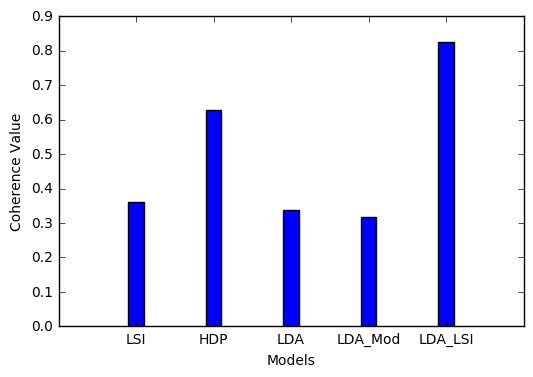

In [102]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [47]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [48]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [49]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [50]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [51]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [52]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [53]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [54]:
print(measure.aggr(confirmed_measures))

-11.2873225334


# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.